# Prediction - it's rain or not?

## Imports

In [2]:
import pandas as pd    
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kneed import KneeLocator

from aing import *
from cfica import *
from clustering import *

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'


## Data Loading

In [5]:
# Replace Pluie by the exact file name Exo_Crews... 
data=pd.read_csv("Pluie.csv",sep=";")

# verify your number of observations and columns
# change separator if needed ',' or '\t' ...
print(data.shape[0], "observations (lines) by ", data.shape[1], "features (columns)")



576 observations (lines) by  14 features (columns)


## Data exploration

In [6]:
data.head(5)


,times,sens,TSL_mean,RSL_mean,Rgage,freq,length,cfakr,cfbkr,link,gage,dist,code,company
0,2021-08-28 00:10:00,290 A-B,5.0,-52.7,0.0,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange
1,2021-08-28 00:25:00,290 A-B,5.0,-52.7,0.0,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange
2,2021-08-28 00:40:00,290 A-B,5.0,-52.7,0.0,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange
3,2021-08-28 00:55:00,290 A-B,5.0,-52.8,0.0,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange
4,2021-08-28 01:10:00,290 A-B,5.0,-52.9,0.0,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange


In [7]:
data.tail(5)

,times,sens,TSL_mean,RSL_mean,Rgage,freq,length,cfakr,cfbkr,link,gage,dist,code,company
571,2021-09-02 22:55:00,290 A-B,5.7,-53.7,4.8,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange
572,2021-09-02 23:10:00,290 A-B,5.0,-53.6,1.6,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange
573,2021-09-02 23:25:00,290 A-B,5.0,-53.4,0.8,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange
574,2021-09-02 23:40:00,290 A-B,5.0,-53.4,0.0,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange
575,2021-09-02 23:55:00,290 A-B,5.0,-53.4,0.8,14.5,1.02,0.0473,1.1022,10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1,Meteo_IUT,0.193579,290,Orange


In [8]:
# detection of Meta-Data 
# a Meta-data could be a unique value, or reduced number (Quality code)
metaValue = 1
card = []
for i in range(data.shape[1]):
    card.append(len(data.iloc[:, i].unique()))

# extraction of non Meta information
subset = np.array(card) > metaValue
df = data.loc[:, subset]

print(df.head(n=3))
print("...")
print(df.tail(n=2))


                 times  TSL_mean  RSL_mean  Rgage
0  2021-08-28 00:10:00       5.0     -52.7    0.0
1  2021-08-28 00:25:00       5.0     -52.7    0.0
2  2021-08-28 00:40:00       5.0     -52.7    0.0
...
                   times  TSL_mean  RSL_mean  Rgage
574  2021-09-02 23:40:00       5.0     -53.4    0.0
575  2021-09-02 23:55:00       5.0     -53.4    0.8


In [9]:
# date identification
df.loc[:, 'times']=pd.to_datetime(df.loc[:,"times"], format="%Y-%m-%d %H:%M:%S")
df.set_index("times", inplace=True)
df.loc[:, 'TRSL_mean'] = df.copy()['RSL_mean'] - df.copy()['TSL_mean']

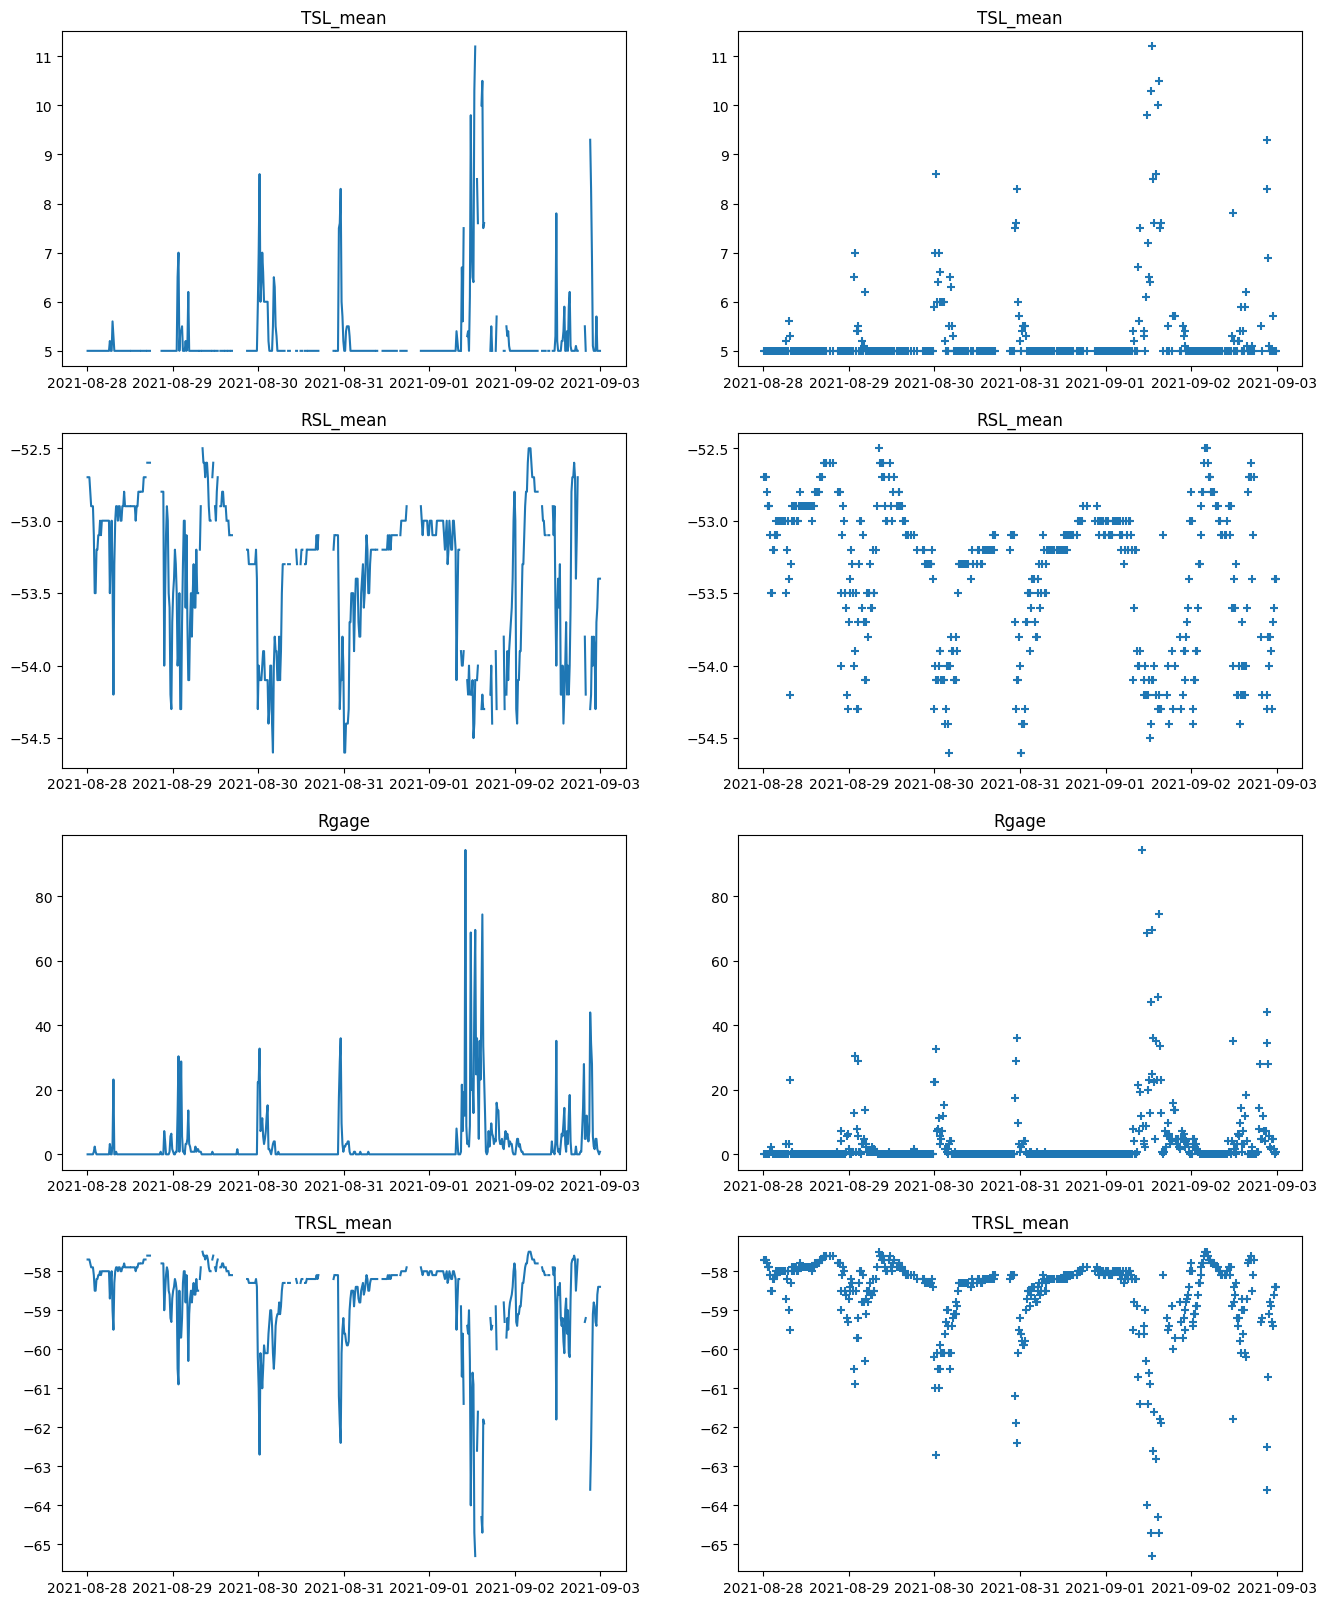

In [10]:
fig, axs = plt.subplots(len(df.columns), 2, figsize=(16, 5 * len(df.columns)))

for i, col in enumerate(df.columns):
    axs[i, 0].plot(df[col])
    axs[i, 0].set_title(col)
    axs[i, 1].scatter(df.index, df[col], marker='+')
    axs[i, 1].set_title(col)

plt.show()


In [11]:
# correlation information
df.corr().round(2)

,TSL_mean,RSL_mean,Rgage,TRSL_mean
TSL_mean,1.00,-0.48,0.95,-0.92
RSL_mean,-0.48,1.00,-0.53,0.78
Rgage,0.95,-0.53,1.00,-0.90
TRSL_mean,-0.92,0.78,-0.90,1.00


## Identification of Pattern by unsupervised approach

In [12]:
#remove observations with NA information 
df.dropna(inplace=True)
df.describe()


,TSL_mean,RSL_mean,Rgage,TRSL_mean
count,451.000000,451.000000,451.000000,451.000000
mean,5.260089,-53.355211,3.249667,-58.615299
std,0.814482,0.505954,9.118773,1.147213
min,5.000000,-54.600000,0.000000,-65.300000
25%,5.000000,-53.750000,0.000000,-58.800000
50%,5.000000,-53.200000,0.000000,-58.200000
75%,5.000000,-53.000000,1.600000,-58.000000
max,11.200000,-52.500000,74.400000,-57.500000


In [13]:
# Normalisation

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

df_scaled.head()

,TSL_mean,RSL_mean,Rgage,TRSL_mean
0,-0.319685,1.296438,-0.356767,0.798732
1,-0.319685,1.296438,-0.356767,0.798732
2,-0.319685,1.296438,-0.356767,0.798732
3,-0.319685,1.098573,-0.356767,0.711467
4,-0.319685,0.900707,-0.356767,0.624203


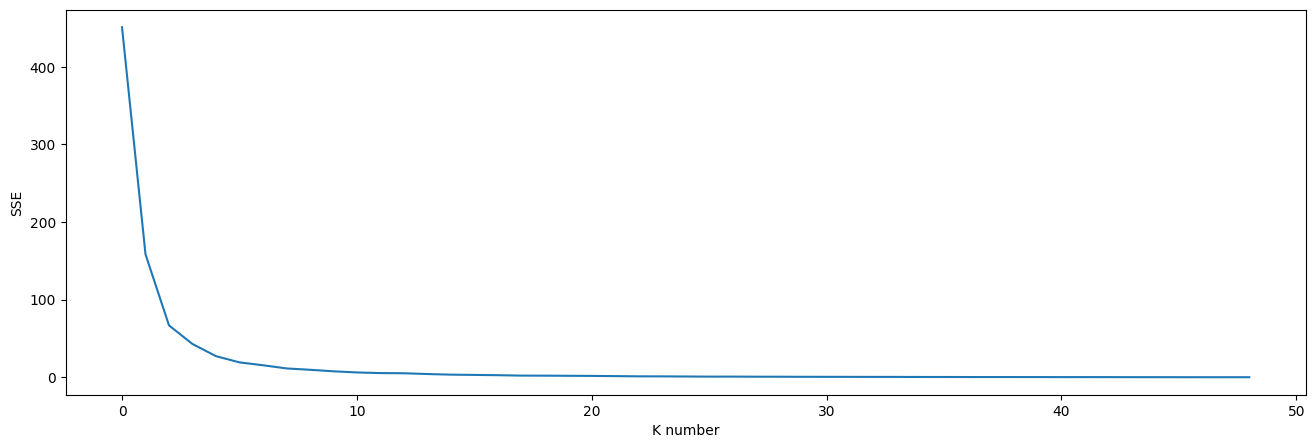

The optimal value of k is: 5


In [15]:
#File 1 identify pattern structure without temporal information
sse = []
Kmax = 50
for k in range(1, Kmax):
    kmeans = KMeans(init = "random", n_clusters = k, n_init = 10, max_iter=300, random_state = 42)
    kmeans.fit(df_scaled[['TRSL_mean']])
    sse.append(kmeans.inertia_)
plt.figure(figsize= (16,5))
plt.xlabel("K number")
plt.ylabel("SSE")
plt.plot(sse)    
plt.show()
kl = KneeLocator(range(1, Kmax), sse, curve="convex", direction="decreasing")
print(f"The optimal value of k is: {kl.elbow}")


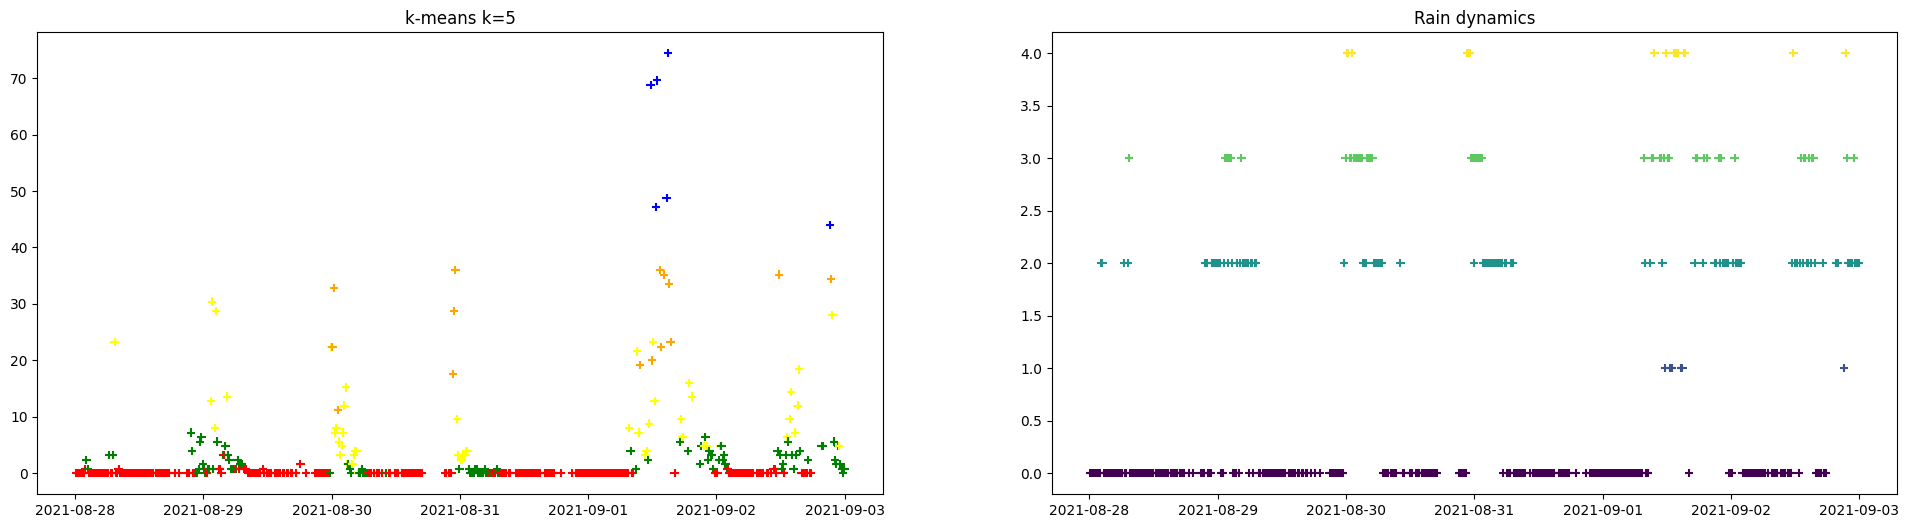

In [18]:
km1 = KMeans(init="random", n_clusters=kl.elbow, n_init=10, max_iter=300, random_state=42)
km1.fit(df_scaled.loc[:, ['TRSL_mean']])

fig, axs = plt.subplots(1, 2, figsize=(24, 6))
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'cyan']
axs[0].scatter(df.index, df['Rgage'], c=[colors[i] for i in km1.labels_], marker='+')
axs[0].set_title(f"k-means k={kl.elbow}", fontdict={"fontsize": 12})

axs[1].scatter(df.index, km1.labels_, c=km1.labels_, marker='+')
axs[1].set_title("Rain dynamics")

plt.show()


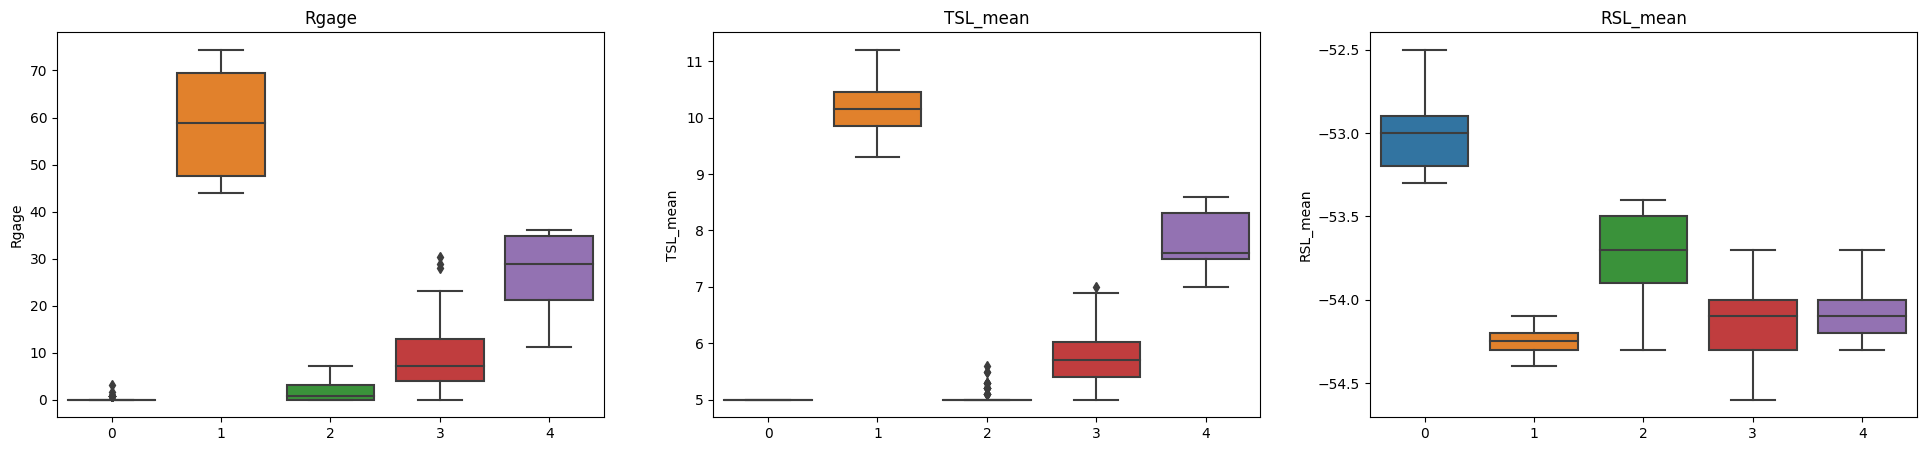

In [19]:
labels = km1.labels_

fig, axs = plt.subplots(1, 3, figsize=(24, 5))

sns.boxplot(y=df.Rgage, x=labels, ax=axs[0])
axs[0].set_title("Rgage")

sns.boxplot(y=df.TSL_mean, x=labels, ax=axs[1])
axs[1].set_title("TSL_mean")

sns.boxplot(y=df.RSL_mean, x=labels, ax=axs[2])
axs[2].set_title("RSL_mean")

plt.show()


# Incremental Clustering

In [50]:
import matplotlib.pyplot as plt

def plot_data(df, y, labels, title):
    fig, axs = plt.subplots(1, 2, figsize=(24, 5))
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'cyan', 'black']
    axs[0].scatter(df.index, y, c=[colors[i] for i in labels], marker='+')
    axs[0].set_xlabel("DateTime")
    axs[0].set_ylabel("Rain Gauge - RGage")
    axs[0].set_title(title)
    axs[1].scatter(df.index, labels, c=[colors[i] for i in labels], marker='+')
    axs[1].set_title("Labels")
    axs[1].set_xlabel("DateTime")
    axs[1].set_ylabel("labels")
    plt.show()


In [52]:
X=df.drop(['Rgage', 'TSL_mean', 'RSL_mean'],axis=1)
y=df.Rgage



In [22]:
clustering =  ProposedApproach(X.values, 150, 50)
clustering.fit()
clustering.cluster_outliers()
labels1 = clustering.labels

In [27]:
cfica = CFICA(X.values, 150, 50)
cfica.fit()
labels2 = cfica.labels

Number of clusters:  2
Labels:  (array([0, 1]), array([132,  18]))
After merging:  3
After merging:  3
After merging:  3
After merging:  4
After merging:  4
After merging:  4
After merging:  4


In [37]:
aing = AING(5)
aing.fit(X.values)
print("Len of the graph: ", len(aing.G))
point_to_neuron = {}
somme = 0
for i in range(len(aing.G)):
    # Handle points assigned to neuron i
    for point in aing.G[i]['points']:
        point_to_neuron[tuple(point)] = i
        somme += 1
        
    # Handle centroid of neuron i
    centroid = aing.G[i]['w']
    somme += 1
    point_to_neuron[tuple(centroid)] = i

labels3 = [point_to_neuron[tuple(point)] for point in X.values]



Len of the graph:  4


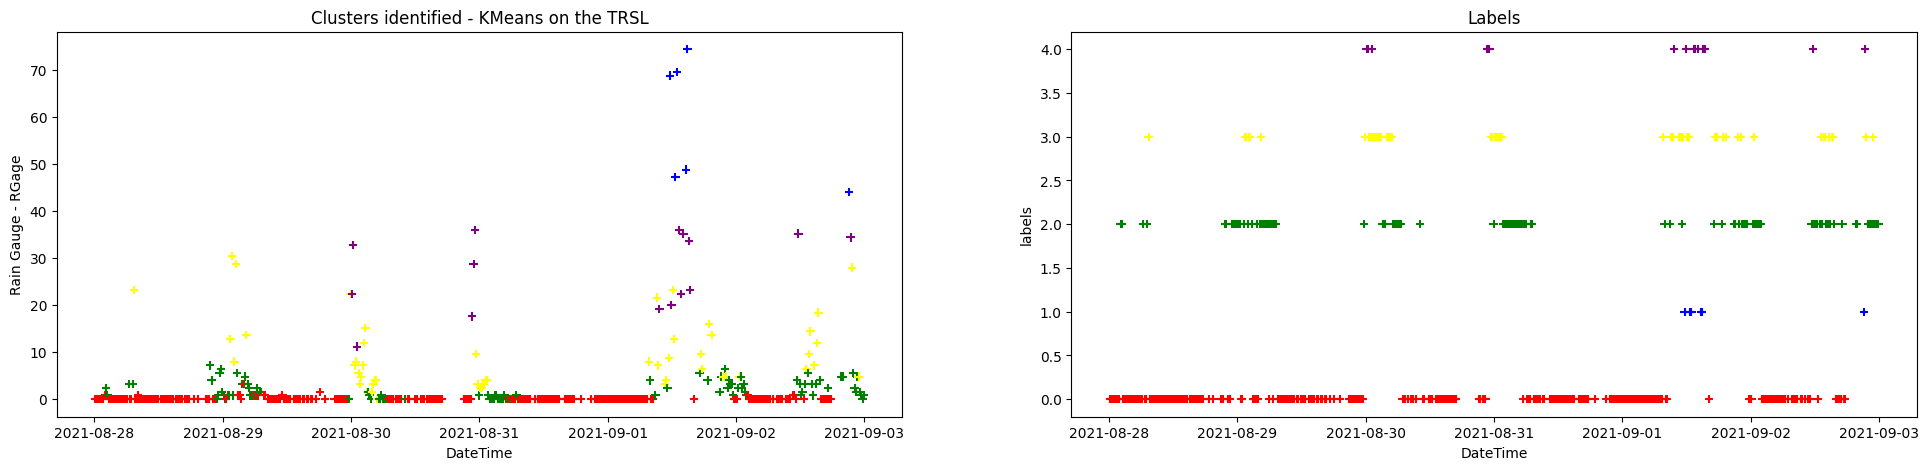

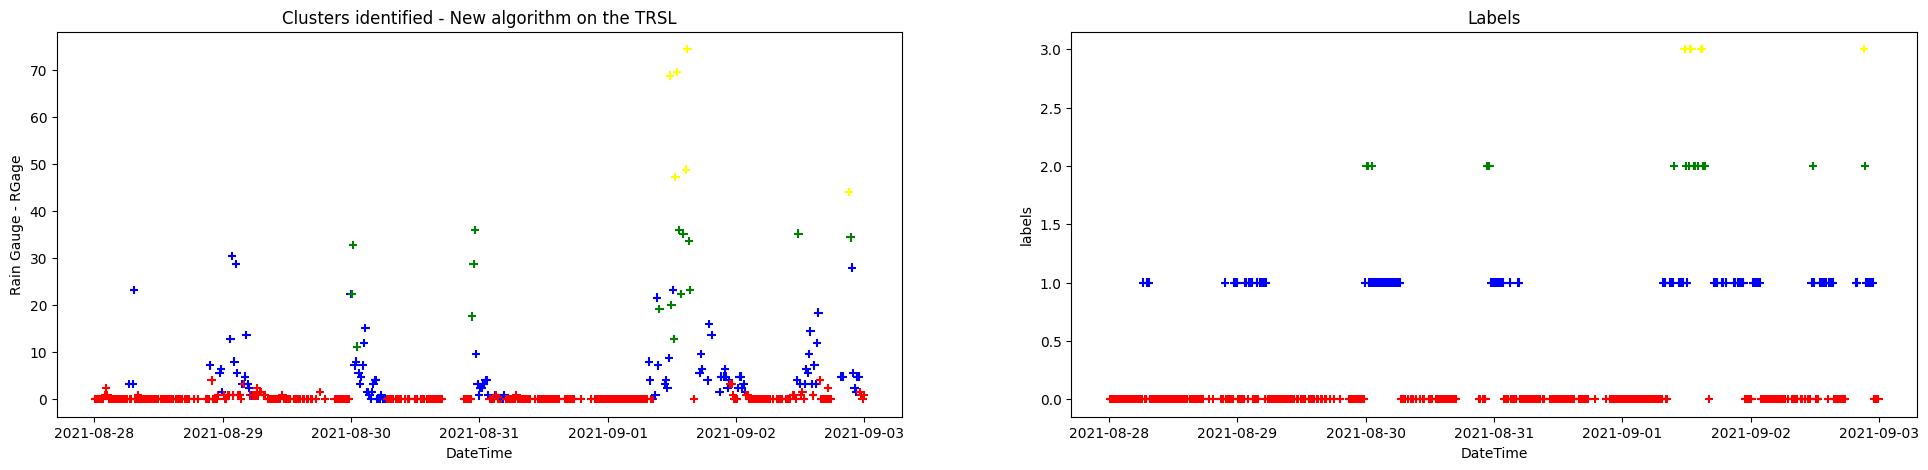

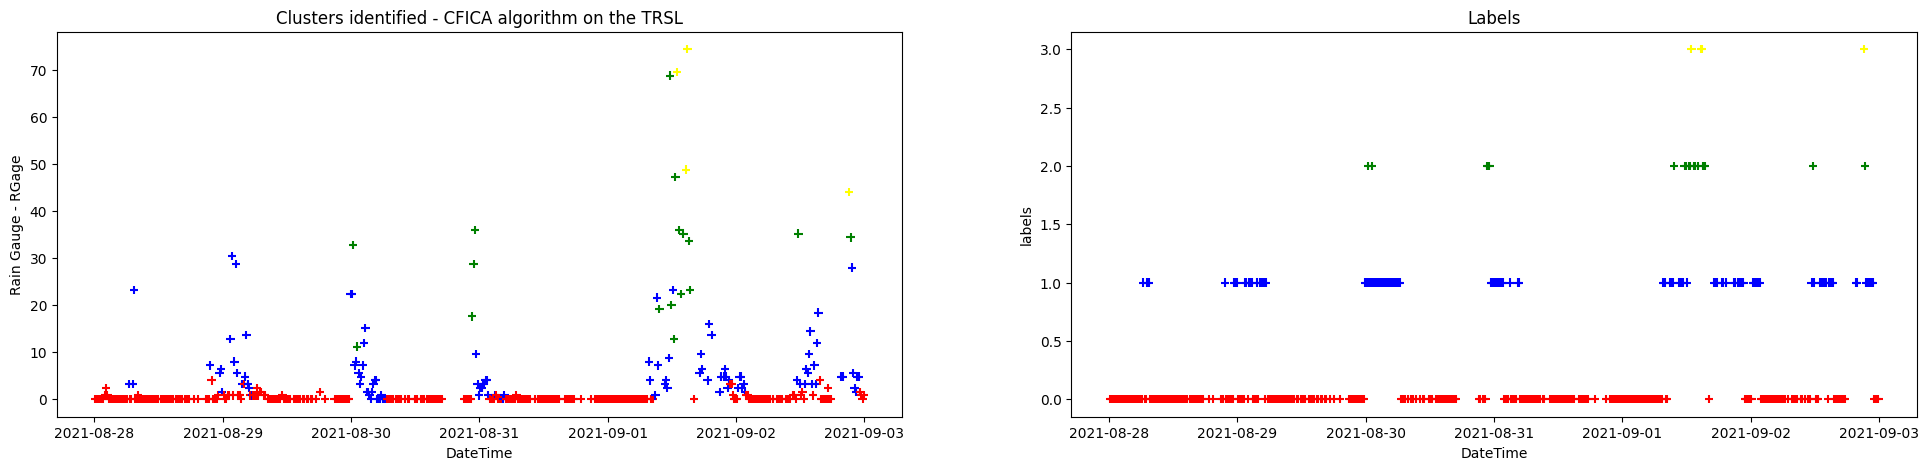

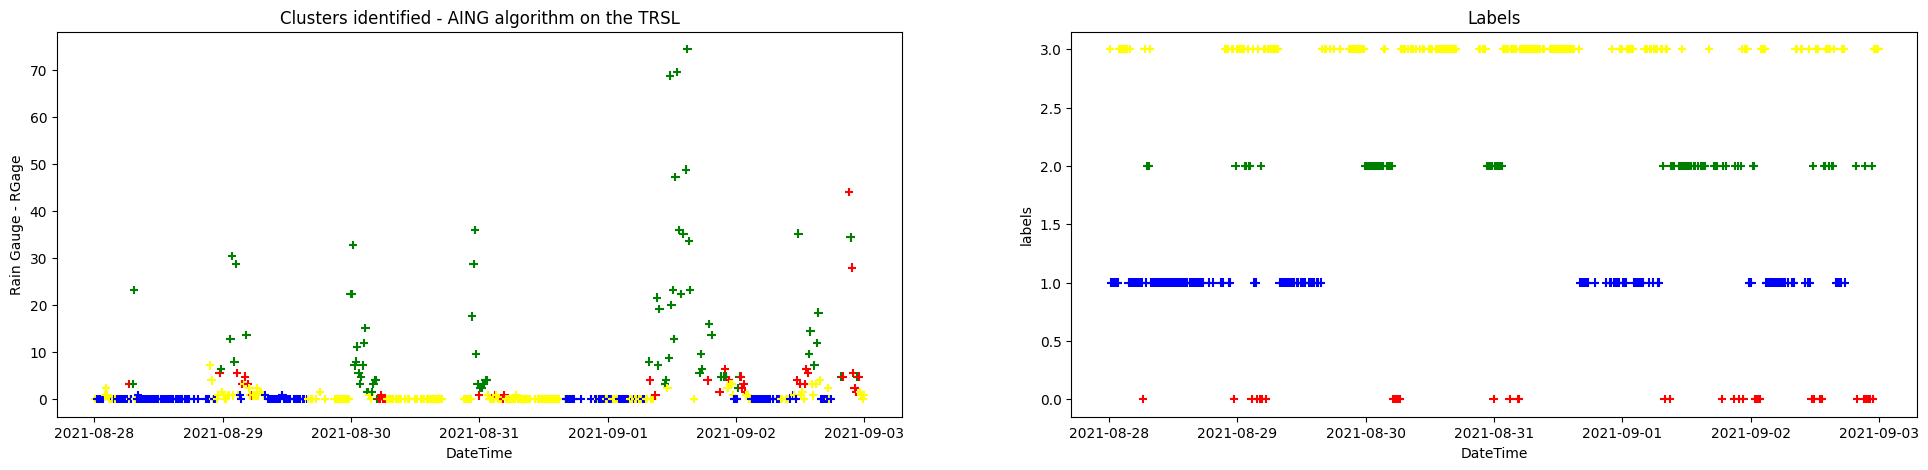

In [51]:
plot_data(df, y, km1.labels_, "Clusters identified - KMeans on the TRSL")
plot_data(df, y, labels1, "Clusters identified - New algorithm on the TRSL")
plot_data(df, y, labels2, "Clusters identified - CFICA algorithm on the TRSL")
plot_data(df, y, labels3, "Clusters identified - AING algorithm on the TRSL")



In [49]:
# import rand index
from sklearn.metrics.cluster import adjusted_rand_score
print("Adjusted rand index Kmeans vs New algo: ", adjusted_rand_score( km1.labels_, labels1))
print("Adjusted rand index New algo vs CFICA algo: ", adjusted_rand_score(labels1, labels2))
print("Adjusted rand index CFICA vs AING", adjusted_rand_score(labels2, labels3))


Adjusted rand index Kmeans vs New algo:  0.6501195123806824
Adjusted rand index New algo vs CFICA algo:  0.9968372918401878
Adjusted rand index CFICA vs AING 0.3957379348607073
